###   1.Анализ производительности graph-500 на локальной машине


Определимся сначала с параметрами теста. В ходе предварительных запусков, оказалось, что на локальной машинке с 4 процессорами увеличение SСALE приводит к колоссальному увеличению времени работы (т.е. для 26 16 - всего лишь Toy размер, дождаться окончания хоть одной итерации не удалось). В итоге, я остановился на стандартном размере SCALE:16 EDGE_FACTOR:16 и запускал mpi-версию в 4 потока:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;<b>mpi-run -np 4 ./graph500_mpi_simple 16 16</b><br>
В результате, по итогам 64 итераций:

<"SCALE:                          16\n"
"edgefactor:                     1\n6
"NBFS:                           64\n"
graph_generation:               0.546302
num_mpi_processes:              4
construction_time:              0.144039
min_time:                       0.147475
firstquartile_time:             0.179075
median_time:                    0.183782
thirdquartile_time:             0.188256
max_time:                       0.232297
mean_time:                      0.183914
stddev_time:                    0.0144824
min_nedge:                      1048570
firstquartile_nedge:            1048570
median_nedge:                   1048570
thirdquartile_nedge:            1048570
max_nedge:                      1048570
mean_nedge:                     1048570
stddev_nedge:                   0
min_TEPS:                       4.51393e+06
firstquartile_TEPS:             5.56993e+06
median_TEPS:                    5.7055e+06
thirdquartile_TEPS:             5.85547e+06
max_TEPS:                       7.11013e+06
harmonic_mean_TEPS:             5.70142e+06
harmonic_stddev_TEPS:           56563.9
min_validate:                   3.30918
firstquartile_validate:         3.99619
median_validate:                4.10362
thirdquartile_validate:         4.21789
max_validate:                   4.51817
mean_validate:                  4.08953
stddev_validate:                0.234609

То есть, по итогам теста, производительность составила: <b>median_TEPS: 5.7055e+06</b>, то есть <b>0.0057055 GTEPS</b>, что в 4 раза хуже последнего (192) места в рейтинге http://www.graph500.org/results_jul_2015


### 3. Определение параметров графа Кронекера

&nbsp;&nbsp;&nbsp;&nbsp;Для того, чтобы определить параметры графа, требуется сперва выписать все его рёбра. Возьмём за основу программку <b>make-edgelist</b> (компонент graph-500 reference code) и слегка её модифицируем: [make-edgelist.c](make-edgelist.c)<br>
&nbsp;&nbsp;&nbsp;&nbsp;В результате, от исходного назначения утилиты не осталось и следа и в stdout она выводит данные в следующем формате:

Заметим, что при генерации графа мы будем использовать параметры: scale=10 и edge_factor=16

Теперь проанализируем параметры этого графа, считав [graph.10-16.data](graph.10-16.data) для этого воспользуемся библиотекой <b>NetworkX</b>

In [123]:
import networkx as nx

In [124]:
def graph_from_file(filename):
    DG = nx.DiGraph()
    with open(filename, 'r') as file:
        header = file.readline()
        scale, N = map(int, header.strip().split())
        # DG.add_nodes_from(range(N))
        for line in file:
            DG.add_edge(*map(int, line.strip().split()))
    return DG

In [125]:
graph = graph_from_file('graph.10-16.data')

In [126]:
graph.number_of_nodes(), graph.number_of_edges()

(887, 10652)

Теперь посчитаем первую интересующую нас характеристику - диаметр графа:

In [127]:
nx.diameter(graph)

NetworkXError: Graph not connected: infinite path length

Наш граф - несвязный! В таком случае, попробуем разбить его на компоненты свзяности. Средствами NetworkX разобьем его на слабосвязные компоненты - так получим более адекватное представление о связях в нём

In [128]:
nx.is_weakly_connected(graph)

True

In [129]:
nx.number_strongly_connected_components(graph) == graph.order()

True

Но тогда попробуем посчитать "Почти диаметр" - максимальный путь != inf

In [130]:
def eccentricity_finite(G):
    """Return the eccentricity of nodes in G.

    The eccentricity of a node v is the maximum distance from v to
    all other nodes in G. Ignore infinite
    """
    order=G.order()

    e={}
    for n in G.nbunch_iter():
        length=nx.single_source_shortest_path_length(G,n)            
        e[n]=max(length.values())
    return e

In [131]:
def diameter(G):
    return max(eccentricity_finite(G).values())

In [132]:
diameter(graph)

9

Аналогично посчитаем среднее расстояние между вершинами

In [133]:
def avg_path_len(G):
    numOfPath = 0
    sumPathLen = 0
    for n in G.nbunch_iter():
        length = nx.single_source_shortest_path_length(G,n)            
        sumPathLen += sum(length.values())
        numOfPath += len(length)
    return float(sumPathLen) / numOfPath

In [134]:
avg_path_len(graph)

TypeError: unsupported operand type(s) for +=: 'int' and 'dict_values'

И построим гистограмму #(n,d)

In [141]:
from collections import Counter
import pylab
import operator

def printGraphDegreeDistribution(gr):
    cnt = Counter()
    for v in gr.degree().values():
        cnt[v] += 1
    #sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(0))
    max_degree = max(list(cnt.keys()))
    out_bins = []
    out_values = []
    for i in range(1, max_degree + 1):
        out_bins.append(i)
        out_values.append(cnt[i])
    pylab.plot(out_bins, out_values)
    pylab.xlabel('degree')
    pylab.ylabel('number')
    pylab.xticks(range(1, max_degree + 1, 9))

In [142]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


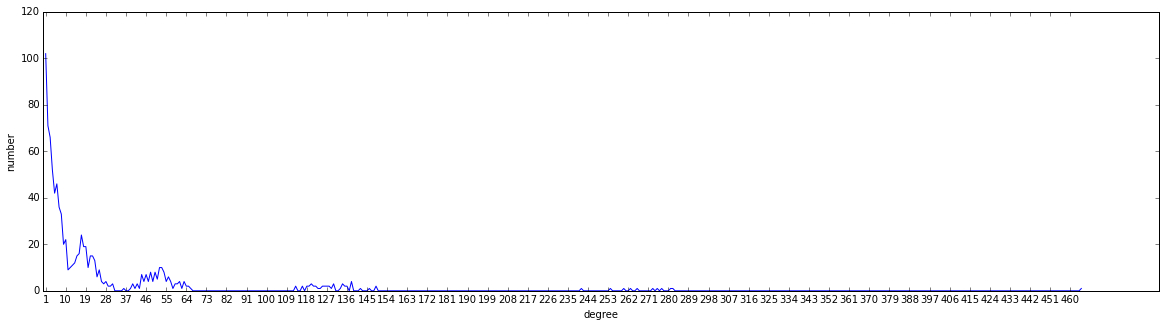

In [144]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

printGraphDegreeDistribution(graph)

По данному графику можно увидеть, что большинство связей имеют небольшую длину, что совпадает с мнением об адекватности использования графа кронекера для иллюстрации социальных связей